In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.impute import SimpleImputer
lr = 0.3
from sklearn import preprocessing

In [2]:
import pandas as pd
# reading csv files
df =  pd.read_csv('heart.dat', sep=" ", header=None)

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0,1
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0,1
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,1
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0,1


In [4]:
column_name = ['age', 'sex', 'chest pain', 'resting blood pressure', 'serum cholestoral', 'fasting blood sugar', 'resting electrocardiographic', 'maximum heart rate achieved',' exercise induced angina', 'oldpeak',' the slope of the peak exercise ST segment', 'number of major vessels', 'tha', 'label']

In [5]:
len(column_name)

14

In [6]:
df.columns = column_name

In [7]:
df = df.fillna(0)

In [8]:
X = df.iloc[:, :-1]

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
trans = StandardScaler()
X = trans.fit_transform(X)

In [10]:
label = df.iloc[:, -1]
#train_date = pd.read_csv('train_date/train_date.csv')

In [11]:
type(label)

pandas.core.series.Series

In [12]:
label = label.map({1:0, 2:1})

In [13]:
label[label==1].shape

(120,)

In [14]:
label[label==0].shape

(150,)

In [15]:
label = np.array(label)

In [16]:
X_Imputed = X

## Feature important

In [17]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f'feature {i}' for i in range(X_Imputed.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_Imputed, label)
importances = forest.feature_importances_

In [18]:
df_imprtance = pd.DataFrame(importances)

In [19]:
#index_top_n_Feature = df_imprtance.sort_values(by=df_imprtance.columns[0],ascending=False).iloc[:8,].index
index_top_n_Feature = df_imprtance.sort_values(by=df_imprtance.columns[0],ascending=False).iloc[:12,].index  

In [20]:
index_top_n_Feature.values

array([12,  2,  7,  9, 11,  4,  0,  3, 10,  8,  1,  6], dtype=int64)

In [21]:
X_Imputed_df = pd.DataFrame(X_Imputed)

In [22]:
X_Imputed_df = X_Imputed_df.iloc[:,index_top_n_Feature.values]

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Imputed_df, label, test_size = 0.3, random_state = 0)

In [24]:
len(label[label==1])

120

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow

def training(X, y, iteration, epoch):
    #iteration = iteration+1
    # define the keras model
    model_path = 'DL_model_Bagging_Numeric/model_'+str(iteration)+'.h5'
    model = Sequential()
    model.add(Dense(248, input_dim=X.shape[-1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2,  activation = "softmax"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    model.fit(X, y, 
              epochs=epoch,
              batch_size=2000,
              validation_split=0.25,
              verbose=0,
              #class_weight=class_weights, 
              callbacks = [LearningRateScheduler(lr_scheduler, verbose=0),
                                    tensorflow.keras.callbacks.ModelCheckpoint(model_path,
                                                                               monitor='val_loss',
                                                                               save_best_only=True,
                                                                               mode='min',
                                                                               verbose=0)])
    print("======================= Done for iteration ", iteration) 
    #model.save('DL_model_Bagging_Numeric/model_'+str(iteration)+'.h5')
    #return model.predict(X)

## Device data into bag

In [26]:
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')


In [27]:
from tensorflow.keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    if epoch % 50 == 0 and epoch:
        lr = lr - lr*0.1
        return lr
    return lr

In [28]:
from tensorflow.keras.models import load_model

def model_Predict(X):
    RM_predicted =[]
    for i in range(0, num_Interation):
        model = load_model('DL_model_Bagging_Numeric/model_'+str(i)+".h5")
        RM_predicted.append(model.predict(X))
    
        
    return RM_predicted

In [29]:
from sklearn.metrics import confusion_matrix
# Plot ROC
def roc_plot(y_real, y_predict):    
    from sklearn.metrics import roc_curve, auc    
    fpr, tpr, thresholds = roc_curve(y_real, y_predict)
    auc = auc(fpr, tpr)
    #print('Auc: ',auc)
    #lw = 2
    #plt.figure(1)
    #plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr, tpr, label='Sleep disorder (area = {:.3f})'.format(auc))
    #plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc))
    #plt.xlabel('False positive rate')
    #plt.ylabel('True positive rate')
    #plt.title('ROC curve')    
    #plt.legend(loc='lower right')
    #plt.show()
    return auc
    
import math
def conf_matrix(y_real, y_predict):
    tn, fp, fn, tp = confusion_matrix(y_real, y_predict).ravel()
    #print('confusion matrix: (tn, fp, fn, tp)',tn, fp, fn, tp)
    #print('acc= ', (tp + tn)/(tp+tn+fp+fn))
    #print('pre= ', tp/(tp+fp))
    #print('sen= Recall= ', (tp)/(tp+fn))
    #print('spec= ', (tn)/(tn+fp))
    #print('F1score= ', 2*(tp)/(2*tp+fp+fn))      
    #print('mcc= ', ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    
    
    acc= (tp + tn)/(tp+tn+fp+fn)
    pre= tp/(tp+fp)
    Recall=  (tp)/(tp+fn)
    spec= (tn)/(tn+fp)
    F1score= (2*(tp)/(2*tp+fp+fn))
    mcc= ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    
    
    return tn, fp, fn, tp, acc, pre, Recall, spec, F1score, mcc

## Running on Multiple

In [30]:
## Running on CLU 2, epoch 500

In [31]:
### from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

import timeit
import tracemalloc
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical



# split 10 fold of undersampling
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve


max_auc = 0.88

for time in range(0, 1):
    print("working on num_Interation: " + str(time))
    rsFile = "Result_OverIteration_Bagging_Numeric/TimeCalcualation_"+str(time)+".csv"
    f2=open(rsFile,"w")
    f2.write('num_Interation, epoch, Time_train, Train_Peak_RAM, Time_predict, Peak_Time_prediction, thres, tn, fp, fn, tp, acc, pre, Recall, spec, F1score, mcc, auc\n')
    for num_Interation in ([1]): #range(1, 50):
        
        for epoch in ([440]): # range(10, 500, 10):

            



            X_train_List=[]
            y_train_List = []

            for i in range(0, num_Interation):
                X_over, y_over = undersample.fit_resample(X_train, y_train)
                X_train_List.append(X_over.values)

                y_over = to_categorical(y_over)
                y_train_List.append(y_over)

            X_train_List = np.array(X_train_List)
            y_train_List = np.array(y_train_List)

            X_train_List = np.array(X_train_List)
            y_train_List = np.array(y_train_List)



            start = timeit.default_timer()
            tracemalloc.start()

            ## Start training
            for i in range(0, num_Interation):
                training(X_train_List[i], y_train_List[i], i, epoch)

            current, peak = tracemalloc.get_traced_memory()
            stop = timeit.default_timer()
            Time_train=stop - start
            Train_Peak_RAM = peak / 10**6
            #print('traning time: ', Time_train)
            #print('Peak_Time:', Train_Peak_RAM)





            start = timeit.default_timer()
            tracemalloc.start()

            predicted = model_Predict(X_test)

            stop = timeit.default_timer()
            Time_predict=stop - start
            current, peak = tracemalloc.get_traced_memory()
            Peak_Time_prediction = peak / 10**6






            result = np.array([[0]*predicted[i].shape[1]]*predicted[i].shape[0])

            for i in range(0, num_Interation):
                #print(result)
                result = result+ predicted[i]
                ##print('*=================')





            auc=roc_auc_score(y_test, result[:, 1]/num_Interation)
            #print('y_test.shape ' ,y_test.shape)
            #print('==========================================')
            #print(result[:, 1]/num_Interation)
            #print('result.shape ', result.shape)

            if max_auc <= auc:
                #max_auc = auc
                print('===================: ')
                print('======= AUC ==============: ', auc)
                print('=====AUC===AUC=====: ')
                print('===AUC========AUC==: ')
                print('=AUC===========AUC=: ')
                print('=AUC===========AUC=: ')
                print('=AUC===========AUC=: ')
                print('===================: ')
                print('===================: ')

            thres = result.min()
            while (thres <= result.max()):
            #for thres in range(1, 1001):
                thres = thres+result.max()/500
                yhat = []
                for i in range(len(result)):
                    if result[i][0]>thres:
                        yhat.append(0)
                    else:
                        yhat.append(1)

                yhat = np.array(yhat)

                tn, fp, fn, tp, acc, pre, Recall, spec, F1score, mcc = conf_matrix(y_test, yhat)
                #auc = roc_plot(y_test, yhat)
                f2.write(str(num_Interation)+", "+str(epoch)+", "+str(Time_train)+", "+str(Train_Peak_RAM)+", "+str(Time_predict)+", "+str(Peak_Time_prediction)+", "+str(thres)+", "+str(tn)+", "+str(fp)+", "+str(fn)+", "+str(tp)+", "+str(acc)+", "+str(pre)+", "+str(Recall)+", "+str(spec)+", "+str(F1score)+", "+str(mcc)+", "+str(auc)+"\n")


    f2.close()
    print('WRITING FILE SUCESSFULL ========!!!!!!!!!!!!!!!!!!!!!!')       

working on num_Interation: 0
======================= Done for iteration  0
===================: 
======= AUC ==============:  0.8832070707070707
=====AUC===AUC=====: 
===AUC========AUC==: 
=AUC===========AUC=: 
=AUC===========AUC=: 
=AUC===========AUC=: 
===================: 
===================: 
WRITING FILE SUCESSFULL ========!!!!!!!!!!!!!!!!!!!!!!


In [32]:
from sklearn.metrics import confusion_matrix
# Plot ROC
def roc_plot(y_real, y_predict):    
    from sklearn.metrics import roc_curve, auc    
    fpr, tpr, thresholds = roc_curve(y_real, y_predict)
    auc = auc(fpr, tpr)
    print('Auc: ',auc)
    lw = 2
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Sleep disorder (area = {:.3f})'.format(auc))
    #plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')    
    plt.legend(loc='lower right')
    plt.show()
    
import math
def conf_matrix(y_real, y_predict):
    tn, fp, fn, tp = confusion_matrix(y_real, y_predict).ravel()
    print('confusion matrix: (tn, fp, fn, tp)',tn, fp, fn, tp)
    print('acc= ', (tp + tn)/(tp+tn+fp+fn))
    print('pre= ', tp/(tp+fp))
    print('sen= Recall= ', (tp)/(tp+fn))
    print('spec= ', (tn)/(tn+fp))
    print('F1score= ', 2*(tp)/(2*tp+fp+fn))      
    print('mcc= ', ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    print('confusion matrix: (tn, fp, fn, tp)',tn, fp, fn, tp)
    acc= (tp + tn)/(tp+tn+fp+fn)
    pre= tp/(tp+fp)
    sen= (tp)/(tp+fn)
    spec= (tn)/(tn+fp)
    F1score= 2*(tp)/(2*tp+fp+fn)  
    mcc= ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

    return tn, fp, fn, tp, acc, pre, sen, spec, F1score, mcc

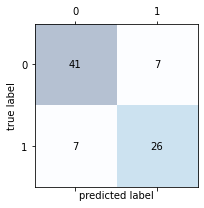

confusion matrix: (tn, fp, fn, tp) 41 7 7 26
acc=  0.8271604938271605
pre=  0.7878787878787878
sen= Recall=  0.7878787878787878
spec=  0.8541666666666666
F1score=  0.7878787878787878
mcc=  0.6420454545454546
confusion matrix: (tn, fp, fn, tp) 41 7 7 26
Auc:  0.8210227272727272


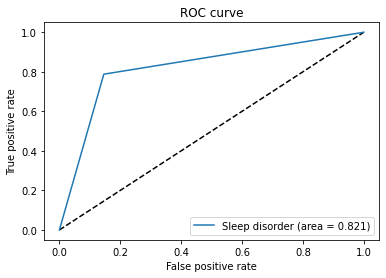

In [33]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


prediction = np.argmax(result, axis=1) 

confmat = confusion_matrix(y_true=y_test, y_pred=prediction)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.show()

conf_matrix(y_test, prediction)
roc_plot(y_test, prediction)

thres:  0.01


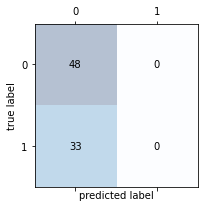

confusion matrix: (tn, fp, fn, tp) 48 0 33 0
acc=  0.5925925925925926
pre=  nan
sen= Recall=  0.0
spec=  1.0
F1score=  0.0
mcc=  nan
confusion matrix: (tn, fp, fn, tp) 48 0 33 0
Auc:  0.5


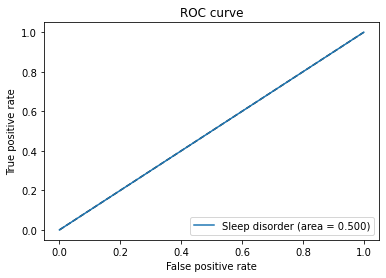

thres:  0.02


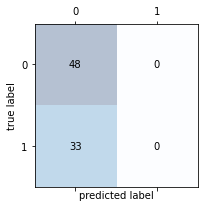

confusion matrix: (tn, fp, fn, tp) 48 0 33 0
acc=  0.5925925925925926
pre=  nan
sen= Recall=  0.0
spec=  1.0
F1score=  0.0
mcc=  nan
confusion matrix: (tn, fp, fn, tp) 48 0 33 0
Auc:  0.5


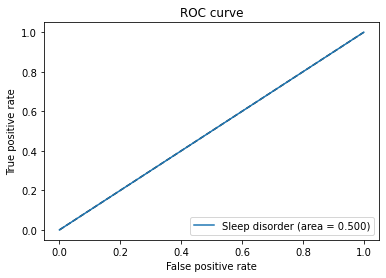

thres:  0.03


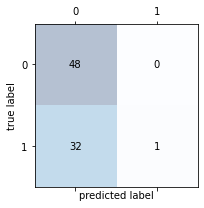

confusion matrix: (tn, fp, fn, tp) 48 0 32 1
acc=  0.6049382716049383
pre=  1.0
sen= Recall=  0.030303030303030304
spec=  1.0
F1score=  0.058823529411764705
mcc=  0.13483997249264842
confusion matrix: (tn, fp, fn, tp) 48 0 32 1
Auc:  0.5151515151515151


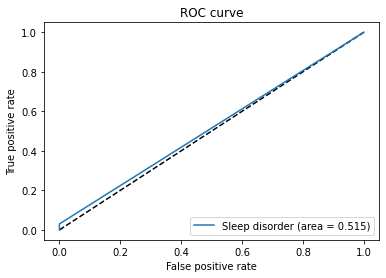

thres:  0.04


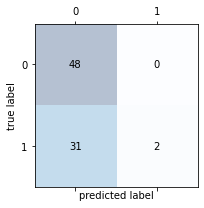

confusion matrix: (tn, fp, fn, tp) 48 0 31 2
acc=  0.6172839506172839
pre=  1.0
sen= Recall=  0.06060606060606061
spec=  1.0
F1score=  0.11428571428571428
mcc=  0.19189563715236668
confusion matrix: (tn, fp, fn, tp) 48 0 31 2
Auc:  0.5303030303030303


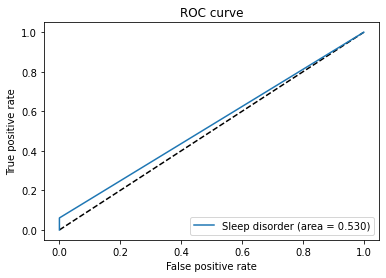

thres:  0.05


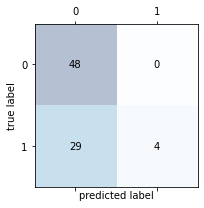

confusion matrix: (tn, fp, fn, tp) 48 0 29 4
acc=  0.6419753086419753
pre=  1.0
sen= Recall=  0.12121212121212122
spec=  1.0
F1score=  0.21621621621621623
mcc=  0.2748832530976198
confusion matrix: (tn, fp, fn, tp) 48 0 29 4
Auc:  0.5606060606060606


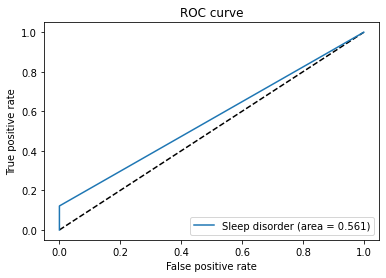

thres:  0.06


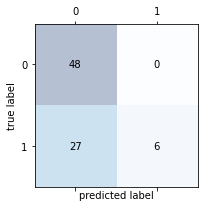

confusion matrix: (tn, fp, fn, tp) 48 0 27 6
acc=  0.6666666666666666
pre=  1.0
sen= Recall=  0.18181818181818182
spec=  1.0
F1score=  0.3076923076923077
mcc=  0.34112114616897665
confusion matrix: (tn, fp, fn, tp) 48 0 27 6
Auc:  0.5909090909090909


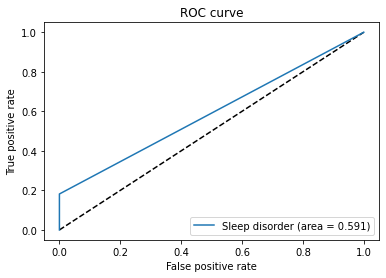

thres:  0.07


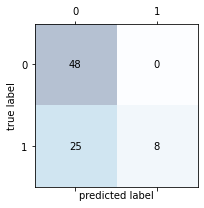

confusion matrix: (tn, fp, fn, tp) 48 0 25 8
acc=  0.691358024691358
pre=  1.0
sen= Recall=  0.24242424242424243
spec=  1.0
F1score=  0.3902439024390244
mcc=  0.39925210280475976
confusion matrix: (tn, fp, fn, tp) 48 0 25 8
Auc:  0.6212121212121212


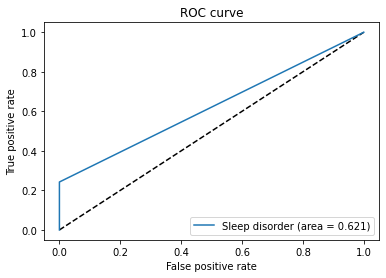

thres:  0.08


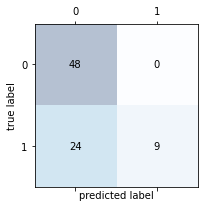

confusion matrix: (tn, fp, fn, tp) 48 0 24 9
acc=  0.7037037037037037
pre=  1.0
sen= Recall=  0.2727272727272727
spec=  1.0
F1score=  0.42857142857142855
mcc=  0.4264014327112209
confusion matrix: (tn, fp, fn, tp) 48 0 24 9
Auc:  0.6363636363636364


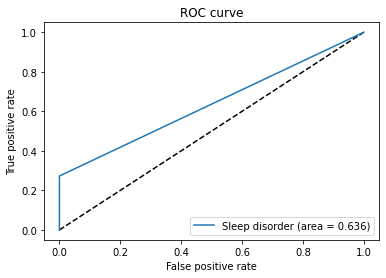

thres:  0.09


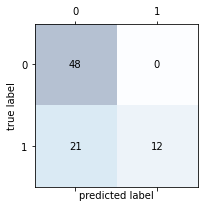

confusion matrix: (tn, fp, fn, tp) 48 0 21 12
acc=  0.7407407407407407
pre=  1.0
sen= Recall=  0.36363636363636365
spec=  1.0
F1score=  0.5333333333333333
mcc=  0.5029556907695453
confusion matrix: (tn, fp, fn, tp) 48 0 21 12
Auc:  0.6818181818181819


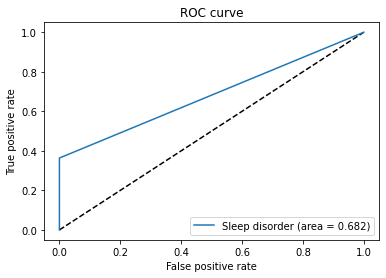

thres:  0.1


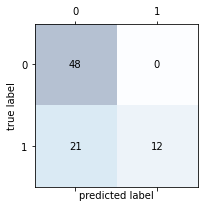

confusion matrix: (tn, fp, fn, tp) 48 0 21 12
acc=  0.7407407407407407
pre=  1.0
sen= Recall=  0.36363636363636365
spec=  1.0
F1score=  0.5333333333333333
mcc=  0.5029556907695453
confusion matrix: (tn, fp, fn, tp) 48 0 21 12
Auc:  0.6818181818181819


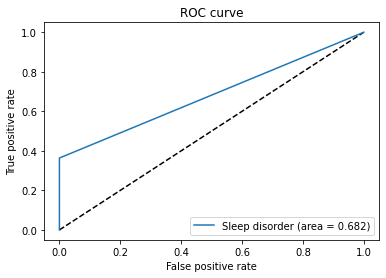

thres:  0.11


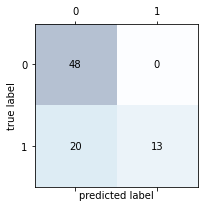

confusion matrix: (tn, fp, fn, tp) 48 0 20 13
acc=  0.7530864197530864
pre=  1.0
sen= Recall=  0.3939393939393939
spec=  1.0
F1score=  0.5652173913043478
mcc=  0.5273280443046439
confusion matrix: (tn, fp, fn, tp) 48 0 20 13
Auc:  0.696969696969697


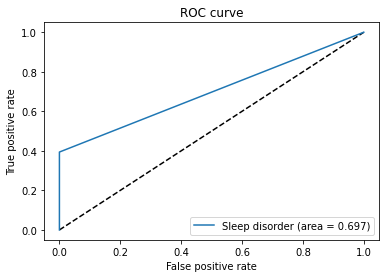

thres:  0.12


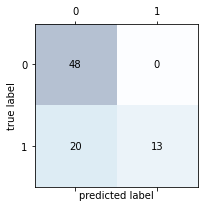

confusion matrix: (tn, fp, fn, tp) 48 0 20 13
acc=  0.7530864197530864
pre=  1.0
sen= Recall=  0.3939393939393939
spec=  1.0
F1score=  0.5652173913043478
mcc=  0.5273280443046439
confusion matrix: (tn, fp, fn, tp) 48 0 20 13
Auc:  0.696969696969697


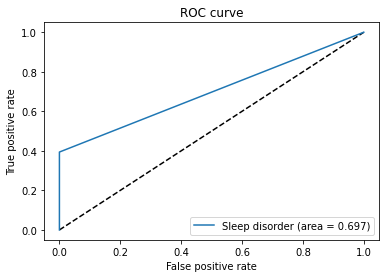

thres:  0.13


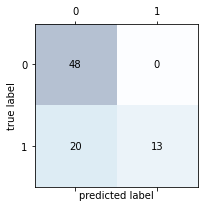

confusion matrix: (tn, fp, fn, tp) 48 0 20 13
acc=  0.7530864197530864
pre=  1.0
sen= Recall=  0.3939393939393939
spec=  1.0
F1score=  0.5652173913043478
mcc=  0.5273280443046439
confusion matrix: (tn, fp, fn, tp) 48 0 20 13
Auc:  0.696969696969697


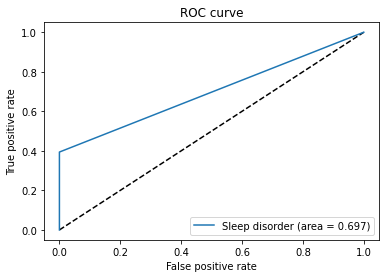

thres:  0.14


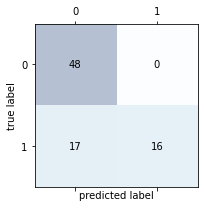

confusion matrix: (tn, fp, fn, tp) 48 0 17 16
acc=  0.7901234567901234
pre=  1.0
sen= Recall=  0.48484848484848486
spec=  1.0
F1score=  0.6530612244897959
mcc=  0.5983660736054126
confusion matrix: (tn, fp, fn, tp) 48 0 17 16
Auc:  0.7424242424242424


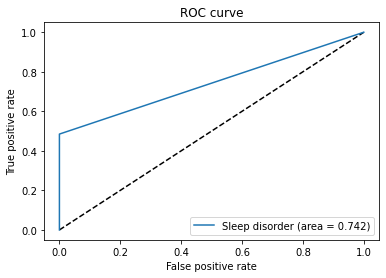

thres:  0.15


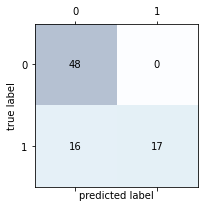

confusion matrix: (tn, fp, fn, tp) 48 0 16 17
acc=  0.8024691358024691
pre=  1.0
sen= Recall=  0.5151515151515151
spec=  1.0
F1score=  0.68
mcc=  0.621581560508061
confusion matrix: (tn, fp, fn, tp) 48 0 16 17
Auc:  0.7575757575757576


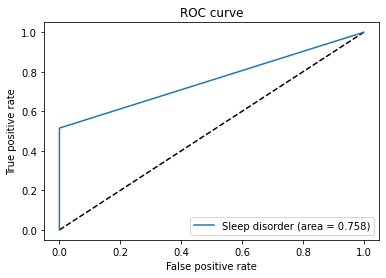

thres:  0.16


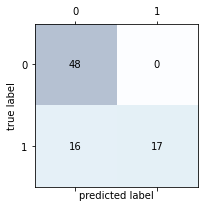

confusion matrix: (tn, fp, fn, tp) 48 0 16 17
acc=  0.8024691358024691
pre=  1.0
sen= Recall=  0.5151515151515151
spec=  1.0
F1score=  0.68
mcc=  0.621581560508061
confusion matrix: (tn, fp, fn, tp) 48 0 16 17
Auc:  0.7575757575757576


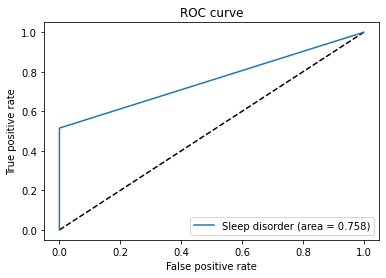

thres:  0.17


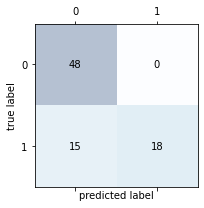

confusion matrix: (tn, fp, fn, tp) 48 0 15 18
acc=  0.8148148148148148
pre=  1.0
sen= Recall=  0.5454545454545454
spec=  1.0
F1score=  0.7058823529411765
mcc=  0.6446583712203042
confusion matrix: (tn, fp, fn, tp) 48 0 15 18
Auc:  0.7727272727272727


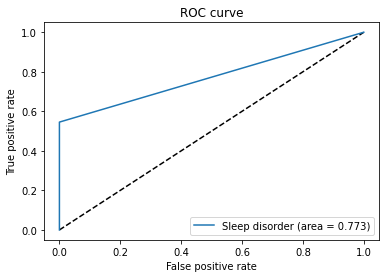

thres:  0.18


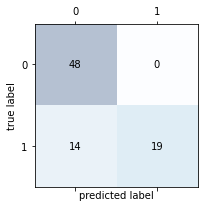

confusion matrix: (tn, fp, fn, tp) 48 0 14 19
acc=  0.8271604938271605
pre=  1.0
sen= Recall=  0.5757575757575758
spec=  1.0
F1score=  0.7307692307692307
mcc=  0.6676434681673372
confusion matrix: (tn, fp, fn, tp) 48 0 14 19
Auc:  0.7878787878787878


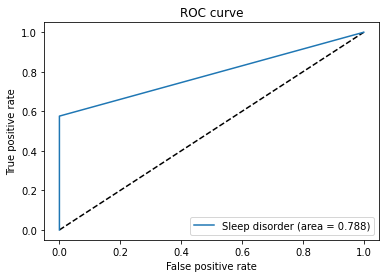

thres:  0.19


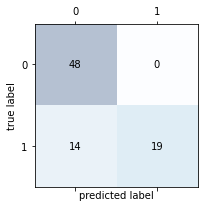

confusion matrix: (tn, fp, fn, tp) 48 0 14 19
acc=  0.8271604938271605
pre=  1.0
sen= Recall=  0.5757575757575758
spec=  1.0
F1score=  0.7307692307692307
mcc=  0.6676434681673372
confusion matrix: (tn, fp, fn, tp) 48 0 14 19
Auc:  0.7878787878787878


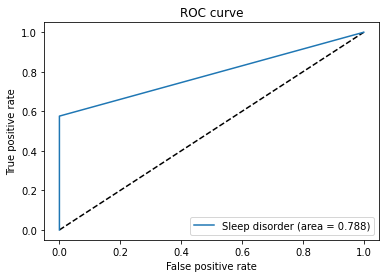

thres:  0.2


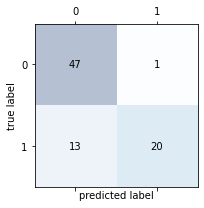

confusion matrix: (tn, fp, fn, tp) 47 1 13 20
acc=  0.8271604938271605
pre=  0.9523809523809523
sen= Recall=  0.6060606060606061
spec=  0.9791666666666666
F1score=  0.7407407407407407
mcc=  0.6561707589759429
confusion matrix: (tn, fp, fn, tp) 47 1 13 20
Auc:  0.7926136363636362


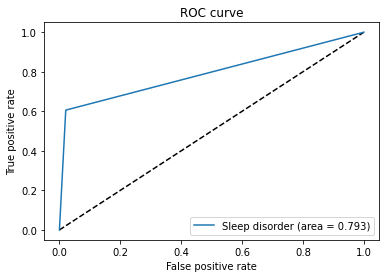

thres:  0.21


KeyboardInterrupt: 

In [34]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

for thres in range(1, 1001):
    print('thres: ', thres/100)
    yhat = []
    thres=thres/100
    for i in range(len(result)):
        if result[i][0]>thres:
            yhat.append(0)
        else:
            yhat.append(1)

    yhat = np.array(yhat)

    confmat = confusion_matrix(y_true=y_test, y_pred=yhat)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
    plt.xlabel('predicted label')        
    plt.ylabel('true label')
    plt.show()

    conf_matrix(y_test, yhat)
    roc_plot(y_test, yhat)

### 